# Ellipse

The notebook contains demonstrations of ellipse-line intersection and ellipse tangent point calculation algorithms used in constructing the target for the keypoint model.

In [3]:
cd soccernet-calibration-sportlight/

/home/cesarlojo/soccernet-calibration-sportlight


/home/cesarlojo/soccernet-calibration-sportlight/tfgenv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
import cv2
import numpy as np

from ellipse import LsqEllipse
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from src.models.hrnet.dataset import HRNetDataset
from src.datatools.geom import find_longest_line
from src.datatools.ellipse import ellipse_line_intersect, find_tangent_point

%load_ext autoreload
%autoreload 2

### Load the data

In [7]:
# dataset_path = '/workdir/data/dataset/valid/'
dataset_path = 'data/dataset/valid/'
STRIDE = 8
SIGMA = 7
IMG_SIZE = (540, 960)
dataset = HRNetDataset(dataset_path, transform=None)

{'Circle central': [{'x': 317.10684165358543, 'y': 372.7185043692589}, {'x': 355.5417429506779, 'y': 342.95373141765594}, {'x': 422.8066357076168, 'y': 319.90396320819855}, {'x': 519.8604218363762, 'y': 305.50818687677383}, {'x': 632.2881627678871, 'y': 302.62605023384094}, {'x': 688.9815556406975, 'y': 305.50818687677383}, {'x': 815.8242923021317, 'y': 318.9457461833954}, {'x': 876.3611238598824, 'y': 335.27295982837677}, {'x': 938.8234759569168, 'y': 360.2316765189171}, {'x': 959.0, 'y': 380.39927595853806}, {'x': 959.0, 'y': 418.8030053973198}, {'x': 921.524086356163, 'y': 439.9287897348404}, {'x': 858.1026894450188, 'y': 462.0053697824478}, {'x': 718.7704775929451, 'y': 477.3743342757225}, {'x': 615.9477036595345, 'y': 478.3325834274292}, {'x': 502.56097507476807, 'y': 466.81142604351044}, {'x': 431.45258647203445, 'y': 454.32459819316864}, {'x': 368.03124672174454, 'y': 432.24056470394135}, {'x': 331.514320731163, 'y': 412.0804829597473}, {'x': 319.983833193779, 'y': 395.760722756

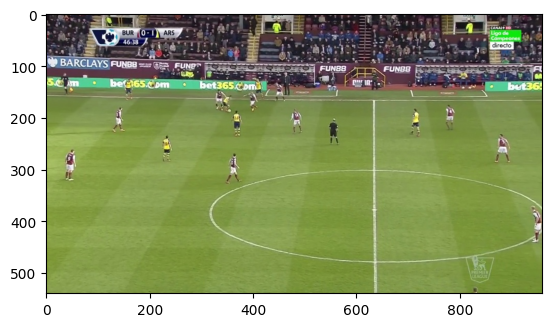

In [8]:
sample = dataset[30]
annot = sample['raw_annot']
img = sample['image'][:, :, ::-1]
print(annot)
plt.imshow(img)

In [9]:
circ_x = [s['x'] for s in annot['Circle central']]
circ_y = [s['y'] for s in annot['Circle central']]
line_x = [s['x'] for s in annot['Middle line']]
line_y = [s['y'] for s in annot['Middle line']]

### Line-ellipse intersection

In [10]:

conic = np.array(list(zip(circ_x, circ_y)))
line = np.array(list(zip(line_x, line_y)))

reg = LsqEllipse().fit(conic)
conic_coeffs = reg.coefficients
a, b = np.polyfit(line[:, 0], line[:, 1], 1)

res = ellipse_line_intersect(conic_coeffs, line)
print('Line-ellipse intersection coordinates:\n', res)

Line-ellipse intersection coordinates:
 [[636.5950714  478.64112015]
 [634.30964817 302.35574382]]


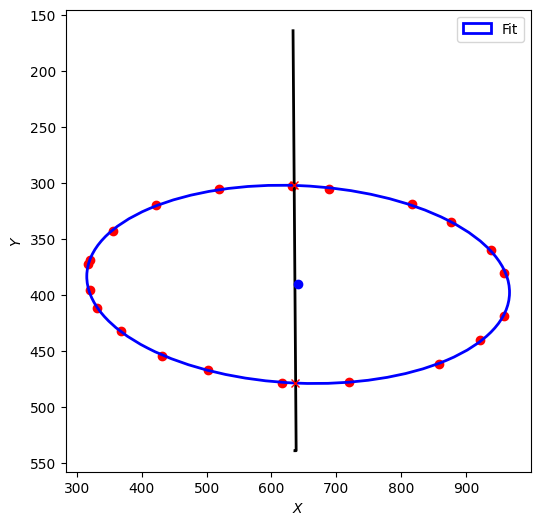

In [11]:
center, width, height, phi = reg.as_parameters()
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
plt.gca().invert_yaxis()
ax.plot(circ_x, circ_y, 'ro', zorder=1)  #  Red points - The points from the annotation
ellipse = Ellipse(
        xy=center, width=2*width, height=2*height, angle=np.rad2deg(phi),
        edgecolor='b', fc='None', lw=2, label='Fit', zorder=2
    )  # Blue line - the fitted ellipse
ax.add_patch(ellipse)
ax.plot(line_x, line_y, color='k', linestyle='-', linewidth=2)  # The black line
ax.plot(center[0], center[1], 'bo')  # Blue point - the calculated center of the ellipse
ax.plot(res[:, 0], res[:, 1], 'rx')  # Red crosses - calculated intersection points of the line and the ellipse

plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

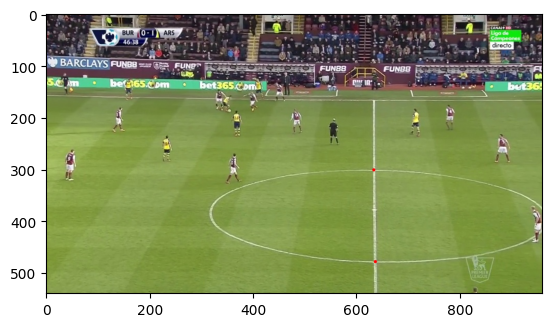

In [12]:
# The line - ellipse intersection point visualization on the original image
img_vis = img.copy()
for point in res:
    point = [int(np.round(p)) for p in point]
    cv2.circle(img_vis, point, 3, (255, 0, 0), -1)
plt.imshow(img_vis)

### Tangent points

In [13]:
point = (line_x[0], line_y[0])
# Find coordinates of two tangent points
px0, py0 = find_tangent_point(conic_coeffs, point, 0)
px1, py1 = find_tangent_point(conic_coeffs, point, 1)
x0, y0 = point
tg_x = (px0, x0, px1)
tg_y = (py0, y0, py1)

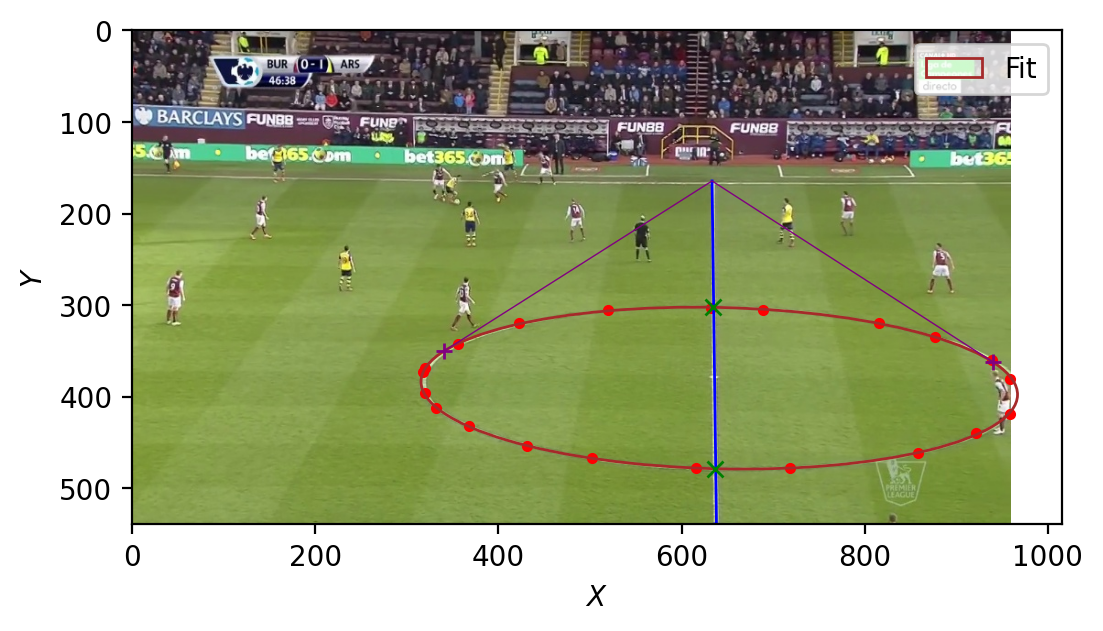

In [14]:
center, width, height, phi = reg.as_parameters()
fig = plt.figure(figsize=(6, 6), dpi=200)
ax = plt.subplot()
ax.imshow(img.copy())
ax.plot(circ_x, circ_y, 'ro', zorder=1, markersize=3)  # Red dots - ellipse points from the annotation

ellipse = Ellipse(
        xy=center, width=2*width, height=2*height, angle=np.rad2deg(phi),
        fc='None', lw=1, label='Fit', zorder=1, color='brown'
    )  # Brown (dark red) line - the ellipse fit
ax.add_patch(ellipse)
ax.plot(line_x, line_y, color='b', linestyle='-', linewidth=1)  # The blue line
ax.plot(tg_x, tg_y, color='purple', linestyle='-', linewidth=0.5)  # Purple lines - the tangent lines
ax.plot(res[:, 0], res[:, 1], 'gx')  # Gren crosses - the calculated line-ellipse intersection points
ax.plot(tg_x[::2], tg_y[::2], 'purple', marker='+', linestyle='none')  # Purple pluses - the calculated tangent points

plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.legend()
plt.show()